# Title    : 螺旋槳性能最佳化應用

In [1]:
# file     : aeronautical_engineering.ipynb
# author   : Ming-Chang Lee
# date     : 2024.11.20
# YouTube  : https://www.youtube.com/@alan9956
# RWEPA    : http://rwepa.blogspot.tw/
# GitHub   : https://github.com/rwepa
# Email    : alan9956@gmail.com

# 大綱
1. 螺旋槳資料集簡介
2. 螺旋槳資料集下載
3. 安裝模組
4. 載入模組
5. 匯入螺旋槳資料集
6. 計算 solidity
7. 資料視覺化
8. Solidity 遺漏值, 使用 KNN 填補法

# 1. 螺旋槳資料集簡介

UIUC螺旋槳資料集: UIUC小型無人機和模型飛機上使用的螺旋槳的風洞測量

UIUC: 伊利諾大學厄巴納－香檳分校（University of Illinois Urbana-Champaign）

# 2. 螺旋槳資料集下載

UIUC螺旋槳原始資料集下載(Kaggle)

https://www.kaggle.com/datasets/heitornunes/uiuc-propeller-database/

參考資料 - CT Prediction | XGBoost

https://www.kaggle.com/code/heitornunes/ct-prediction-xgboost

**研究目標**

建立一個小型螺旋槳的性能模型, 了解其一些特性和飛行條件.

**螺旋槳的性能可以透過三個參數來衡量**

(1).推力係數(Thrust Coefficient)
(2).功率係數(Power Coefficient)
(3).效率(Efficiency)
 
+ 參數取決於葉片幾何形狀(Blade Geometry)、雷諾數(Reynolds Number)和進距比(Advance Ratio)等，本篇文章以推力係數為主。
 
+ 資料集包括實驗資料集、幾何資料集，每個資料集有3種不同版本的資料，合計檔案有6個。

**UIUC螺旋槳資料集下載(RWEPA GitHub)**

https://github.com/rwepa/DataDemo/tree/master/propeller_design
 
一、實驗資料集（Experiment Data Set Features）

11個變數

+ PropName: Propeller's Name.    螺旋槳的名稱
+ BladeName: Blade's Name.       葉片的名稱
+ Family: Propeller's Brand.     螺旋槳品牌
+ B: Number of Blades.           葉片數量
+ D: Propeller's Diameter.       螺旋槳直徑
+ P: Propeller's Pitch.          螺旋槳的螺距
+ J: Advanced Ratio Input.       進階比率輸入
+ N: RPM Rotation Input. RPM     旋轉輸入
+ CT: Thrust Coefficient Output. 推力係數輸出 --> 反應變數
+ CP: Power Coefficient Output.  輸出功率係數
+ eta: Efficiency Output.        效率輸出

二、幾何資料集（Blade Geometry Data Set Features）

8個變數

+ PropName: Propeller's Name.       螺旋槳的名稱
+ BladeName: Blade's Name.          葉片的名稱
+ Family: Propeller's Brand.        螺旋槳品牌
+ D: Propeller's Diameter.          螺旋槳直徑
+ P: Propeller's Pitch.             螺旋槳的螺距
+ r/R: Adimensional Radius.         維度半徑
+ c/R: Adimensional Chord.          維度和弦
+ beta: Angle Relative to Rotation. 相對於旋轉的角度

# 3. 安裝 missingno 模組

+ The missingno provides a small toolset of flexible and easy-to-use missing data visualizations and utilities that allows you to get a quick visual summary of the completeness (or lack thereof) of your dataset.

+ 參考網站: https://github.com/ResidentMario/missingno

+ 安裝模組: pip install missingno

+ pandas, matplotlib, numpy scipy, seaborn, sklearn 已經內建於 Anaconda.

# 4. 載入模組

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msgno
import numpy as np
from scipy.integrate import trapz
import seaborn as sns
from sklearn.impute import KNNImputer

# 5. 匯入螺旋槳資料集

In [3]:
exp1_url = 'https://raw.githubusercontent.com/rwepa/DataDemo/master/propeller_design/volume1_exp.csv'
exp2_url = 'https://raw.githubusercontent.com/rwepa/DataDemo/master/propeller_design/volume2_exp.csv'
exp3_url = 'https://raw.githubusercontent.com/rwepa/DataDemo/master/propeller_design/volume3_exp.csv'

geom1_url = 'https://raw.githubusercontent.com/rwepa/DataDemo/master/propeller_design/volume1_geom.csv'
geom2_url = 'https://raw.githubusercontent.com/rwepa/DataDemo/master/propeller_design/volume2_geom.csv'
geom3_url = 'https://raw.githubusercontent.com/rwepa/DataDemo/master/propeller_design/volume3_geom.csv'


exp1 = pd.read_csv(exp1_url)
exp2 = pd.read_csv(exp2_url)
exp3 = pd.read_csv(exp3_url)

geom1 = pd.read_csv(geom1_url)
geom2 = pd.read_csv(geom2_url)
geom3 = pd.read_csv(geom3_url)

# 合併為一個資料框
data = pd.concat([exp1, exp2, exp3], ignore_index=True) # 27495*11
geom = pd.concat([geom1, geom2, geom3], ignore_index=True) # 2316*7

In [4]:
data # [27495 rows x 11 columns]

PropName     BladeName Family  B    D    P      J         N  \
0      ance 8.5x6.0 - 2  ance 8.5x6.0   ance  2  8.5  6.0  0.165  4000.000   
1      ance 8.5x6.0 - 2  ance 8.5x6.0   ance  2  8.5  6.0  0.214  4000.000   
2      ance 8.5x6.0 - 2  ance 8.5x6.0   ance  2  8.5  6.0  0.255  4000.000   
3      ance 8.5x6.0 - 2  ance 8.5x6.0   ance  2  8.5  6.0  0.301  4000.000   
4      ance 8.5x6.0 - 2  ance 8.5x6.0   ance  2  8.5  6.0  0.340  4000.000   
...                 ...           ...    ... ..  ...  ...    ...       ...   
27490  ancf 9.0x7.0 - 2  ancf 9.0x7.0   ancf  2  9.0  7.0  0.000  5453.333   
27491  ancf 9.0x7.0 - 2  ancf 9.0x7.0   ancf  2  9.0  7.0  0.000  5960.000   
27492  ancf 9.0x7.0 - 2  ancf 9.0x7.0   ancf  2  9.0  7.0  0.000  6466.667   
27493  ancf 9.0x7.0 - 2  ancf 9.0x7.0   ancf  2  9.0  7.0  0.000  6960.000   
27494  ancf 9.0x7.0 - 2  ancf 9.0x7.0   ancf  2  9.0  7.0  0.000  7460.000   

             CT        CP    eta  
0      0.099300  0.053900  0.304  
1      0.094700  0.054300  0.374  
2      0.091600  0.054800  0.427  
3      0.084700  0.054000  0.473  
4      0.079600  0.053000  0.511  
...         ...       ...    ...  
27490  0.123695  0.063178  0.000  
27491  0.123677  0.063333  0.000  
27492  0.124291  0.063651  0.000  
27493  0.125048  0.063481  0.000  
27494  0.125666  0.063223  0.000  

[27495 rows x 11 columns]

In [5]:
geom # [2316 rows x 7 columns]

BladeName   Family    D         P     c/R   r/R    beta
0     apc29ff 9.0x5.0  apc29ff  9.0  5.000000  0.1600  0.15  31.680
1     apc29ff 9.0x5.0  apc29ff  9.0  5.000000  0.1460  0.20  34.450
2     apc29ff 9.0x5.0  apc29ff  9.0  5.000000  0.1440  0.25  35.930
3     apc29ff 9.0x5.0  apc29ff  9.0  5.000000  0.1430  0.30  33.330
4     apc29ff 9.0x5.0  apc29ff  9.0  5.000000  0.1430  0.35  29.420
...               ...      ...  ...       ...     ...   ...     ...
2311     union 9x7.72    union  9.0  7.718262  0.2752  0.80  13.576
2312     union 9x7.72    union  9.0  7.718262  0.2668  0.85  12.258
2313     union 9x7.72    union  9.0  7.718262  0.2567  0.90  10.807
2314     union 9x7.72    union  9.0  7.718262  0.2182  0.95   8.551
2315     union 9x7.72    union  9.0  7.718262  0.0964  1.00   2.932

[2316 rows x 7 columns]

In [6]:
# 資料摘要
tmp = data.describe(include='all')
print(tmp)

                 PropName     BladeName Family             B             D  \
count               27495         27495  27495  27495.000000  27495.000000   
unique                240           226     32           NaN           NaN   
top     gwsdd 2.5x0.8 - 2  nr640 9x5.68   ancf           NaN           NaN   
freq                  243           276   5990           NaN           NaN   
mean                  NaN           NaN    NaN      2.045790      9.443751   
std                   NaN           NaN    NaN      0.266954      2.766641   
min                   NaN           NaN    NaN      2.000000      1.200000   
25%                   NaN           NaN    NaN      2.000000      9.000000   
50%                   NaN           NaN    NaN      2.000000     10.000000   
75%                   NaN           NaN    NaN      2.000000     11.000000   
max                   NaN           NaN    NaN      4.000000     19.000000   

                   P             J             N            CT 

In [7]:
tmp = geom.describe()
print(tmp)

                 D            P          c/R          r/R         beta
count  2316.000000  2316.000000  2316.000000  2316.000000  2316.000000
mean      8.581533     5.571051     0.164200     0.578886    21.451867
std       3.017287     2.337077     0.061546     0.257930     9.536387
min       2.244094     0.787402     0.002100     0.150000     0.000000
25%       5.000000     4.000000     0.132800     0.350000    14.193000
50%       9.000000     6.000000     0.161000     0.600000    19.971500
75%      11.000000     7.000000     0.186850     0.800000    27.300000
max      19.000000    13.000000     0.378300     1.000000    55.845000


In [8]:
# 資料型態
data.dtypes

PropName      object
BladeName     object
Family        object
B              int64
D            float64
P            float64
J            float64
N            float64
CT           float64
CP           float64
eta          float64
dtype: object

In [9]:
geom.dtypes

BladeName     object
Family        object
D            float64
P            float64
c/R          float64
r/R          float64
beta         float64
dtype: object

# 6. 計算 solidity

In [10]:
props = data['PropName'].value_counts().index

solidity = pd.DataFrame(columns=['PropName', 'Solidity']) # 建立空的 solidity 資料框

line = ['PropName', 'BladeName', 'Family', 'B', 'D', 'P']

for prop in props:
    
    # 篩選 PropName
    # prop = props[0]
    df_line = data.loc[data['PropName'] == prop, line].drop_duplicates()
    
    # 取出 BladeName 值
    bn = df_line.loc[:, 'BladeName'].item()
    
    # 取出 b 值
    b = df_line.loc[:, 'B'].item()
    
    # 取出 d 值
    d = df_line.loc[:, 'D'].item()
    
    # 從 geom 資料集找出對應 BladeName
    mask = geom['BladeName'] == bn
    
    if mask.sum() == 0:
        continue
    
    df_geom = geom.loc[mask, :]
    
    c = df_geom['c/R'].to_numpy() * d * 0.5
    r = df_geom['r/R'].to_numpy() * d * 0.5
    I = trapz(c, r) # 定積分梯形法則 numpy.trapz(y, x)
    
    sol = np.round(4 * b * I /(d ** 2 * np.pi), 5)
    
    # solidity = solidity.append({'PropName': prop, 'Solidity': sol}, ignore_index=True)
    # pandas.append 方法不再使用
    solidity = pd.concat([solidity, pd.DataFrame({'PropName': [prop], 'Solidity': [sol]})],  ignore_index=True)

C:\Users\rwepa\AppData\Local\Temp\ipykernel_24152\39560926.py:32: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  I = trapz(c, r) # 定積分梯形法則 numpy.trapz(y, x)
C:\Users\rwepa\AppData\Local\Temp\ipykernel_24152\39560926.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  solidity = pd.concat([solidity, pd.DataFrame({'PropName': [prop], 'Solidity': [sol]})],  ignore_index=True)
C:\Users\rwepa\AppData\Local\Temp\ipykernel_24152\39560926.py:32: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  I = trapz(c, r) # 定積分梯形法則 numpy.trapz(y, x)
C:\Users\rwepa\AppData\Local\Temp\ip

In [11]:
# 疏密比(Solidity)
solidity

PropName  Solidity
0      gwsdd 2.5x0.8 - 2   0.30087
1      apcsp 9.0x6.0 - 2   0.07946
2      gwsdd 5.0x4.3 - 2   0.21014
3      gwsdd 9.0x5.0 - 2   0.10450
4     apce 11.0x10.0 - 2   0.07797
..                   ...       ...
129  da4002 5.0x2.65 - 2   0.08951
130  da4002 5.0x1.58 - 2   0.08873
131     nr640 9x7.72 - 4   0.14473
132     nr640 9x7.72 - 3   0.10855
133     nr640 5x4.29 - 4   0.14473

[134 rows x 2 columns]

In [12]:
# 疏密比資料摘要
solidity.describe()

Solidity
count  134.000000
mean     0.099762
std      0.039396
min      0.064620
25%      0.077048
50%      0.086970
75%      0.100240
max      0.300870

In [13]:
# 合併疏密比
data = data.merge(solidity, how = 'left', on = 'PropName')
data

PropName     BladeName Family  B    D    P      J         N  \
0      ance 8.5x6.0 - 2  ance 8.5x6.0   ance  2  8.5  6.0  0.165  4000.000   
1      ance 8.5x6.0 - 2  ance 8.5x6.0   ance  2  8.5  6.0  0.214  4000.000   
2      ance 8.5x6.0 - 2  ance 8.5x6.0   ance  2  8.5  6.0  0.255  4000.000   
3      ance 8.5x6.0 - 2  ance 8.5x6.0   ance  2  8.5  6.0  0.301  4000.000   
4      ance 8.5x6.0 - 2  ance 8.5x6.0   ance  2  8.5  6.0  0.340  4000.000   
...                 ...           ...    ... ..  ...  ...    ...       ...   
27490  ancf 9.0x7.0 - 2  ancf 9.0x7.0   ancf  2  9.0  7.0  0.000  5453.333   
27491  ancf 9.0x7.0 - 2  ancf 9.0x7.0   ancf  2  9.0  7.0  0.000  5960.000   
27492  ancf 9.0x7.0 - 2  ancf 9.0x7.0   ancf  2  9.0  7.0  0.000  6466.667   
27493  ancf 9.0x7.0 - 2  ancf 9.0x7.0   ancf  2  9.0  7.0  0.000  6960.000   
27494  ancf 9.0x7.0 - 2  ancf 9.0x7.0   ancf  2  9.0  7.0  0.000  7460.000   

             CT        CP    eta  Solidity  
0      0.099300  0.053900  0.304       NaN  
1      0.094700  0.054300  0.374       NaN  
2      0.091600  0.054800  0.427       NaN  
3      0.084700  0.054000  0.473       NaN  
4      0.079600  0.053000  0.511       NaN  
...         ...       ...    ...       ...  
27490  0.123695  0.063178  0.000       NaN  
27491  0.123677  0.063333  0.000       NaN  
27492  0.124291  0.063651  0.000       NaN  
27493  0.125048  0.063481  0.000       NaN  
27494  0.125666  0.063223  0.000       NaN  

[27495 rows x 12 columns]

In [14]:
# 欄位名稱
data.columns

Index(['PropName', 'BladeName', 'Family', 'B', 'D', 'P', 'J', 'N', 'CT', 'CP',
       'eta', 'Solidity'],
      dtype='object')

In [15]:
# Solidity 有遺漏值
data.describe(include='all')

PropName     BladeName Family             B             D  \
count               27495         27495  27495  27495.000000  27495.000000   
unique                240           226     32           NaN           NaN   
top     gwsdd 2.5x0.8 - 2  nr640 9x5.68   ancf           NaN           NaN   
freq                  243           276   5990           NaN           NaN   
mean                  NaN           NaN    NaN      2.045790      9.443751   
std                   NaN           NaN    NaN      0.266954      2.766641   
min                   NaN           NaN    NaN      2.000000      1.200000   
25%                   NaN           NaN    NaN      2.000000      9.000000   
50%                   NaN           NaN    NaN      2.000000     10.000000   
75%                   NaN           NaN    NaN      2.000000     11.000000   
max                   NaN           NaN    NaN      4.000000     19.000000   

                   P             J             N            CT            CP  \
count   27495.000000  27495.000000  27495.000000  27495.000000  27495.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        6.420748      0.423310   5470.285834      0.063996      0.046393   
std         2.411737      0.278554   2756.465916      0.044331      0.026629   
min         0.600000      0.000000    940.000000     -0.126140      0.002500   
25%         4.960000      0.208000   4012.000000      0.029395      0.026810   
50%         6.000000      0.429000   5018.000000      0.066372      0.043094   
75%         8.000000      0.622245   6021.000000      0.097700      0.060690   
max        13.000000      1.552000  27050.000000      0.253789      0.192791   

                 eta      Solidity  
count   27495.000000  14211.000000  
unique           NaN           NaN  
top              NaN           NaN  
freq             NaN           NaN  
mean        0.318133      0.098078  
std         0.539775      0.041623  
min       -22.698791      0.064620  
25%         0.133000      0.076890  
50%         0.456781      0.083160  
75%         0.613000      0.097590  
max         0.840262      0.300870

# 7. 資料視覺化

<Axes: >

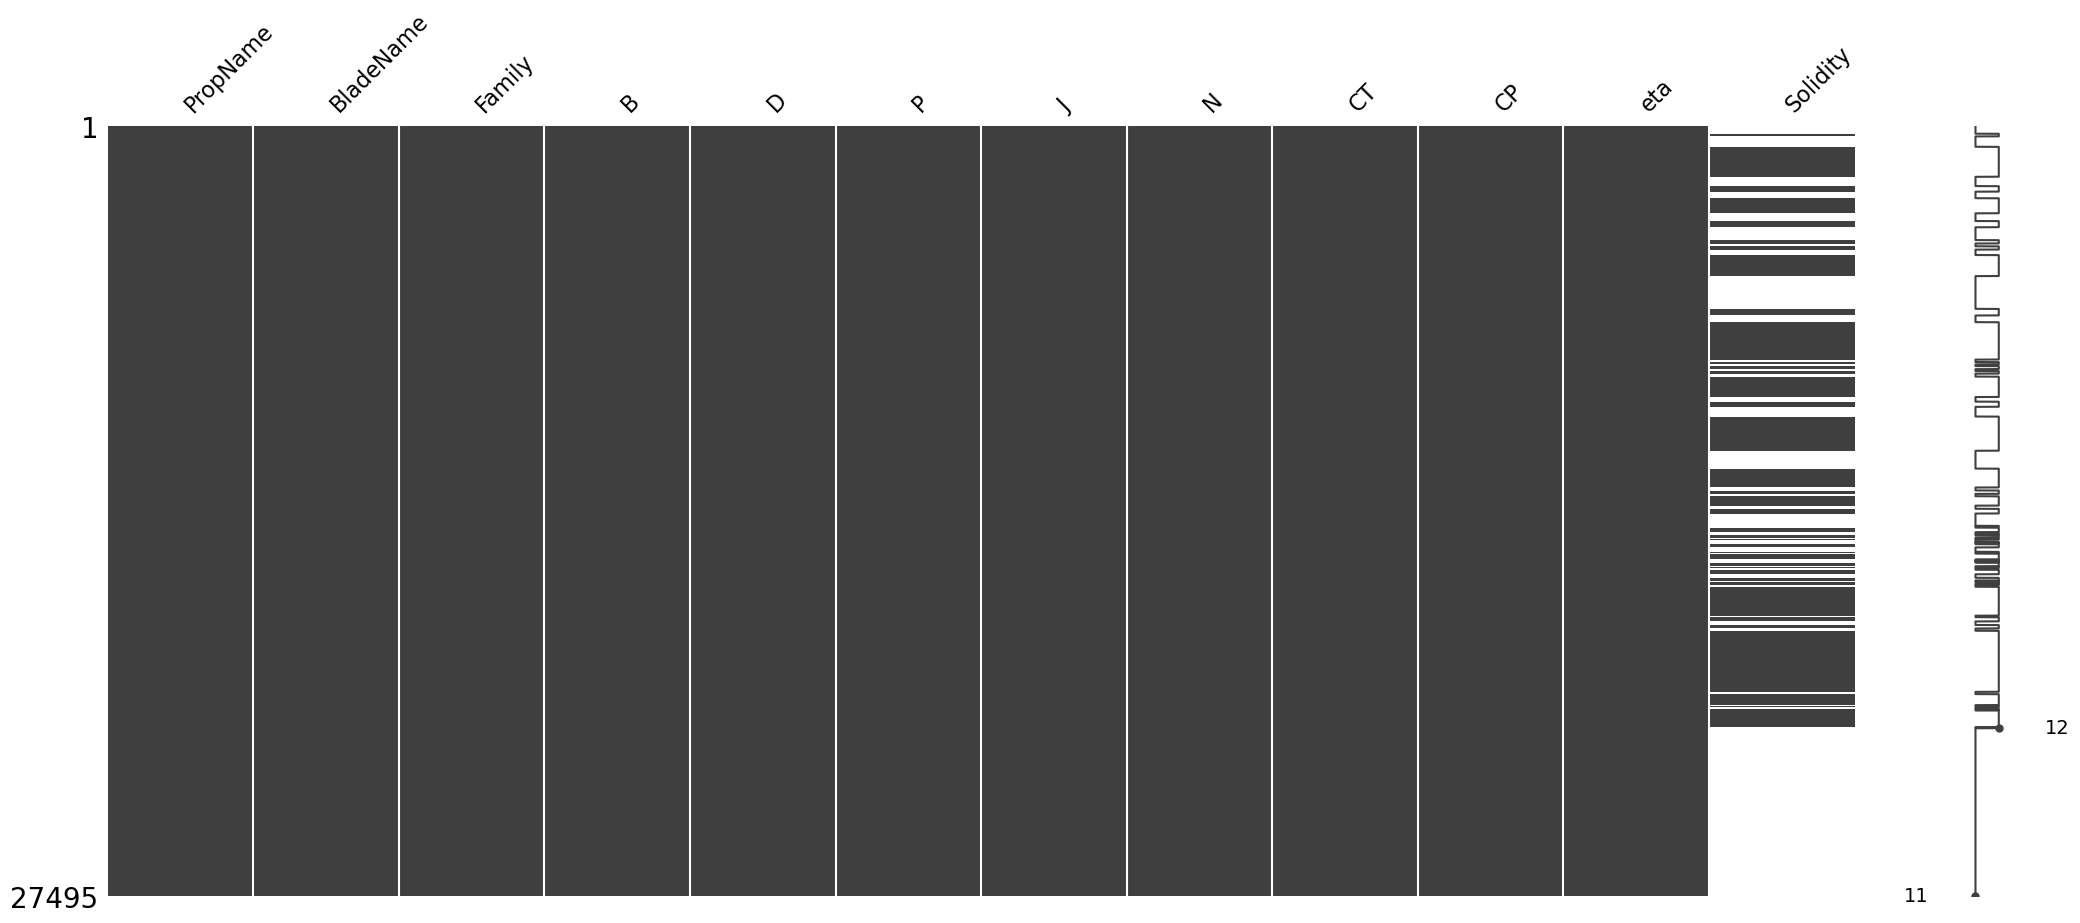

In [16]:
# 白色表示NA
# 右側的迷你圖提供資料完整性的形狀，並指出了資料集具有非空值的最大行數和最小行數。
msgno.matrix(data)

In [17]:
# 建立新的變數"螺距比" pitch ratio (P/D)
data['P/D'] = np.round(data['P']/data['D'], 3)

In [18]:
# 匯出 Excel 檔案
data.to_excel("data_6_files.xlsx", index=False)

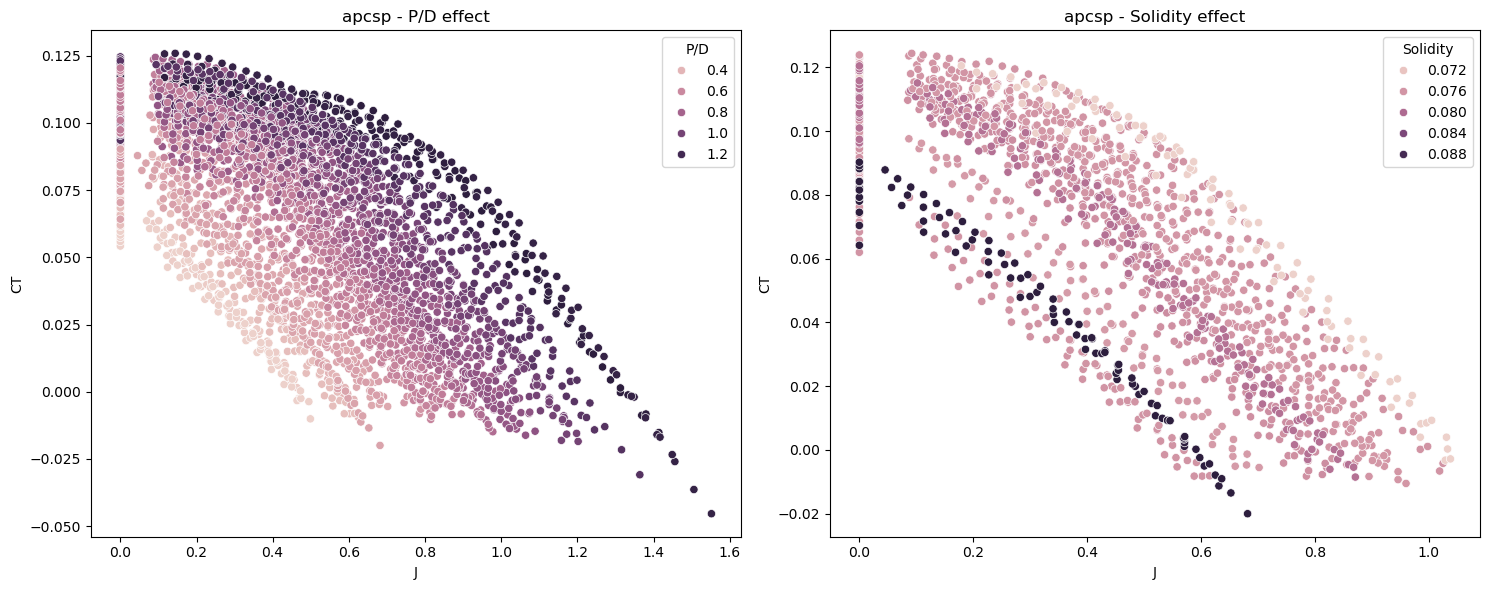

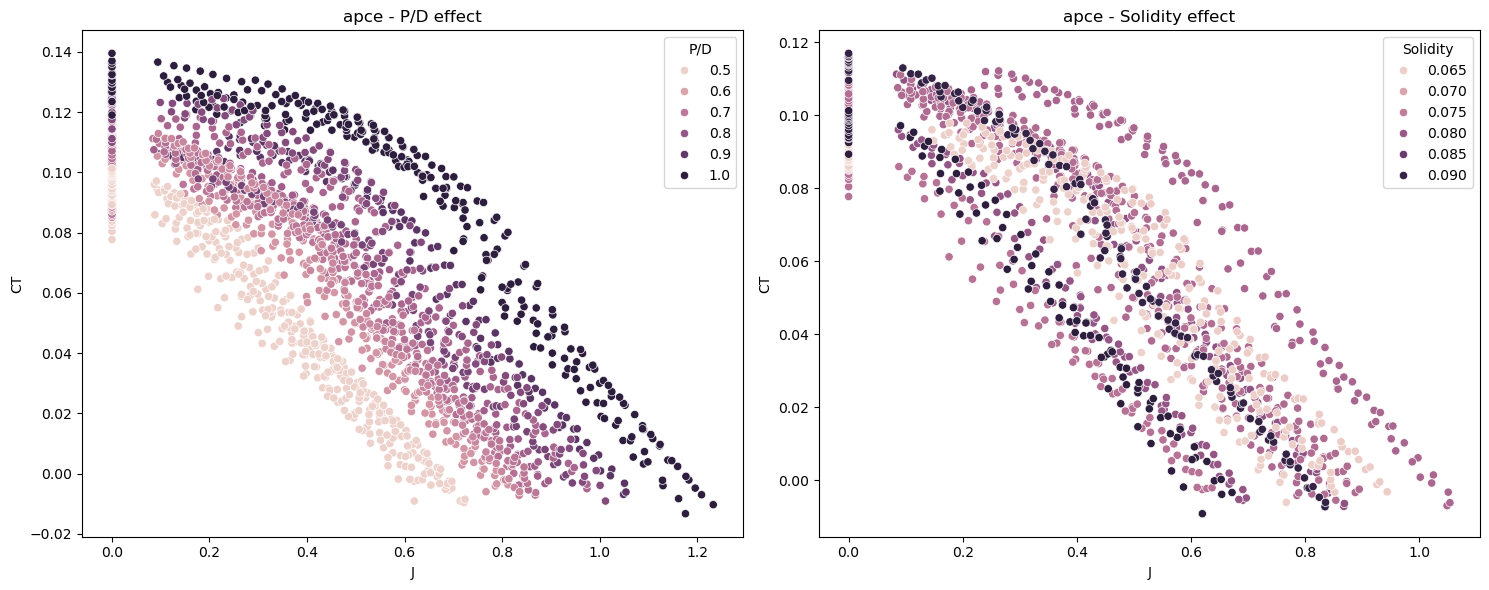

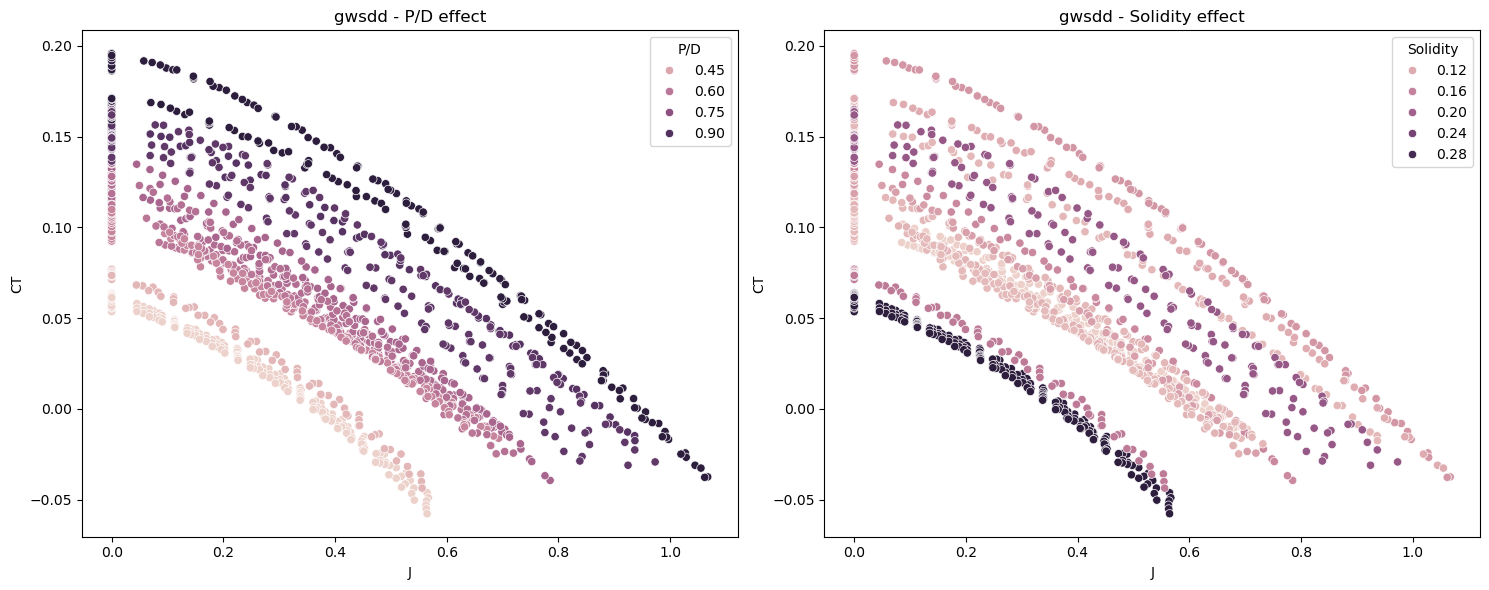

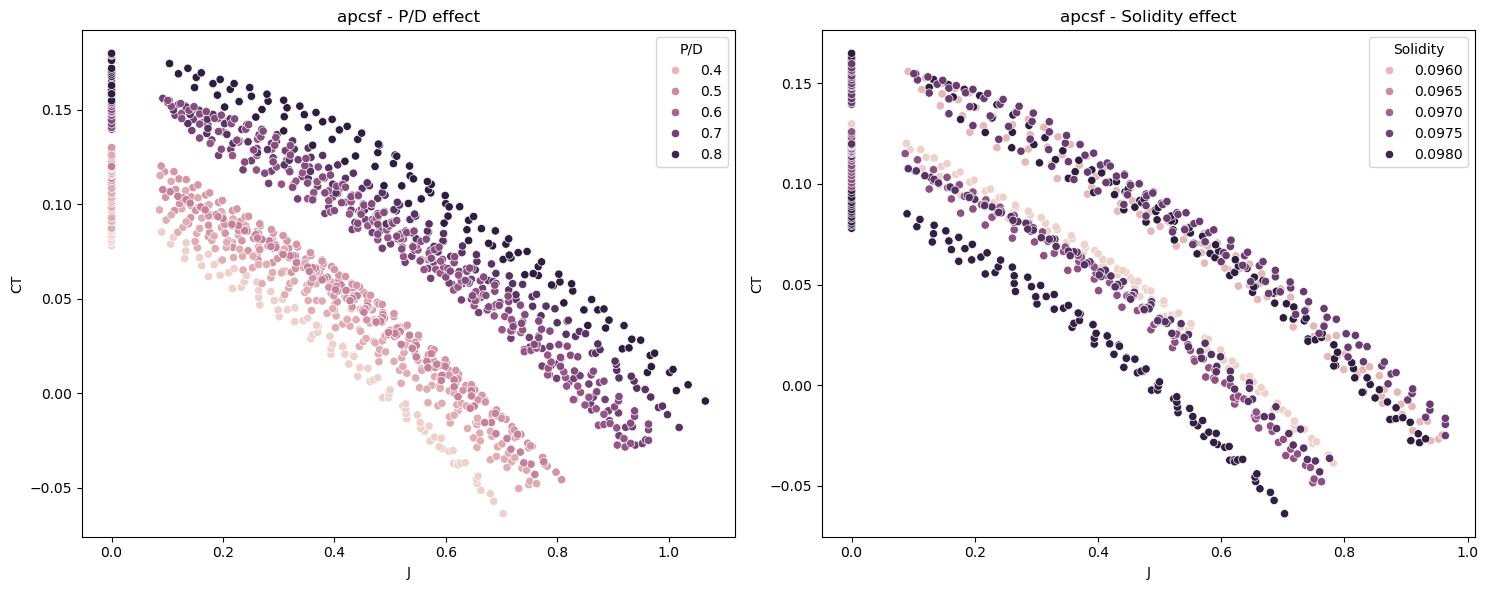

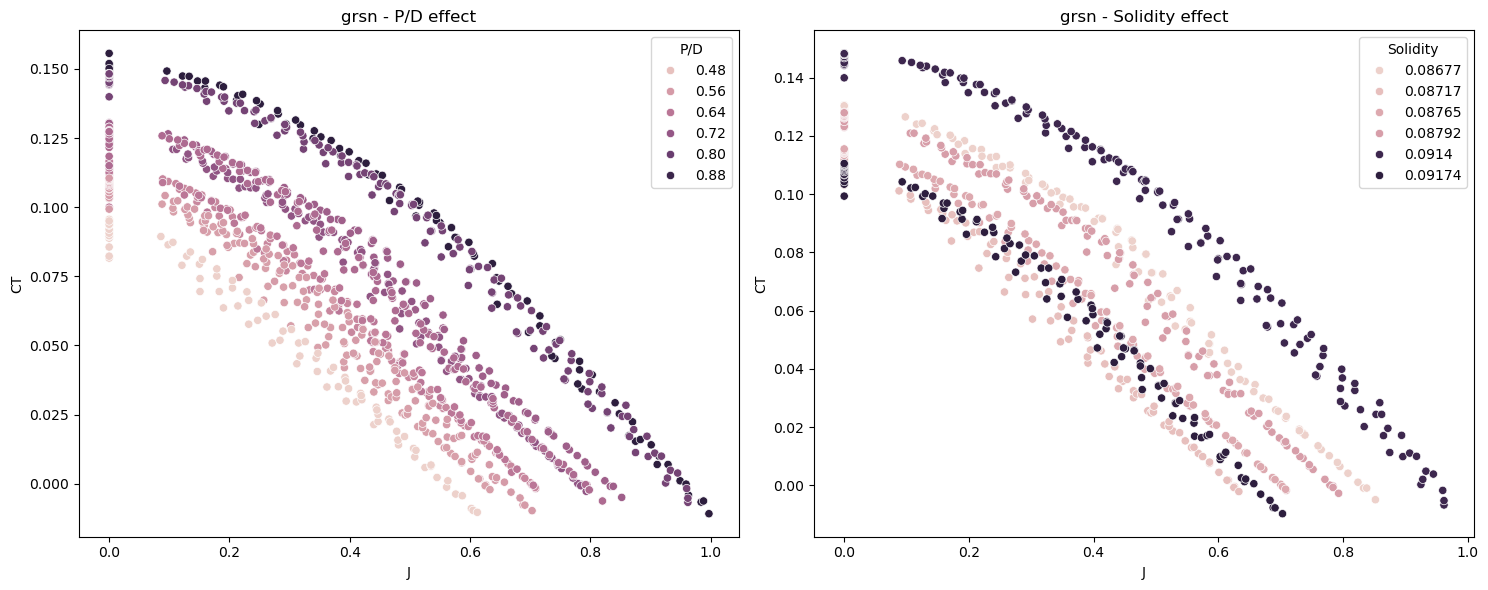

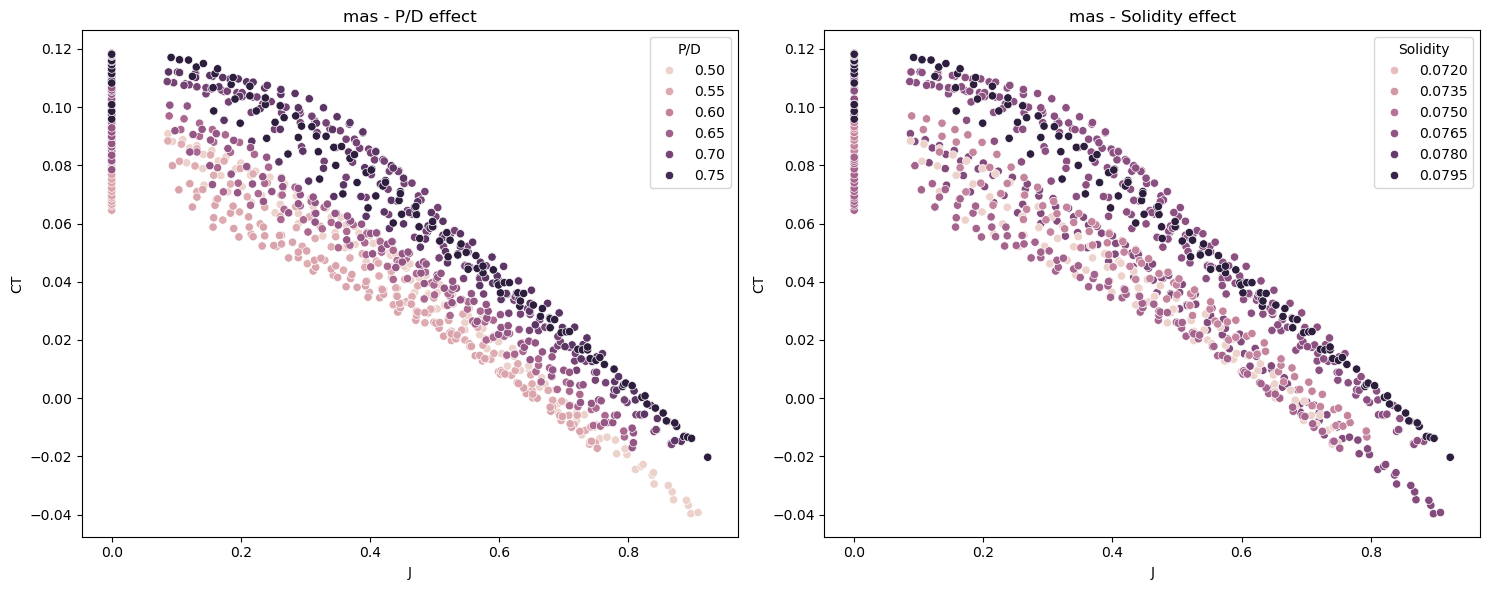

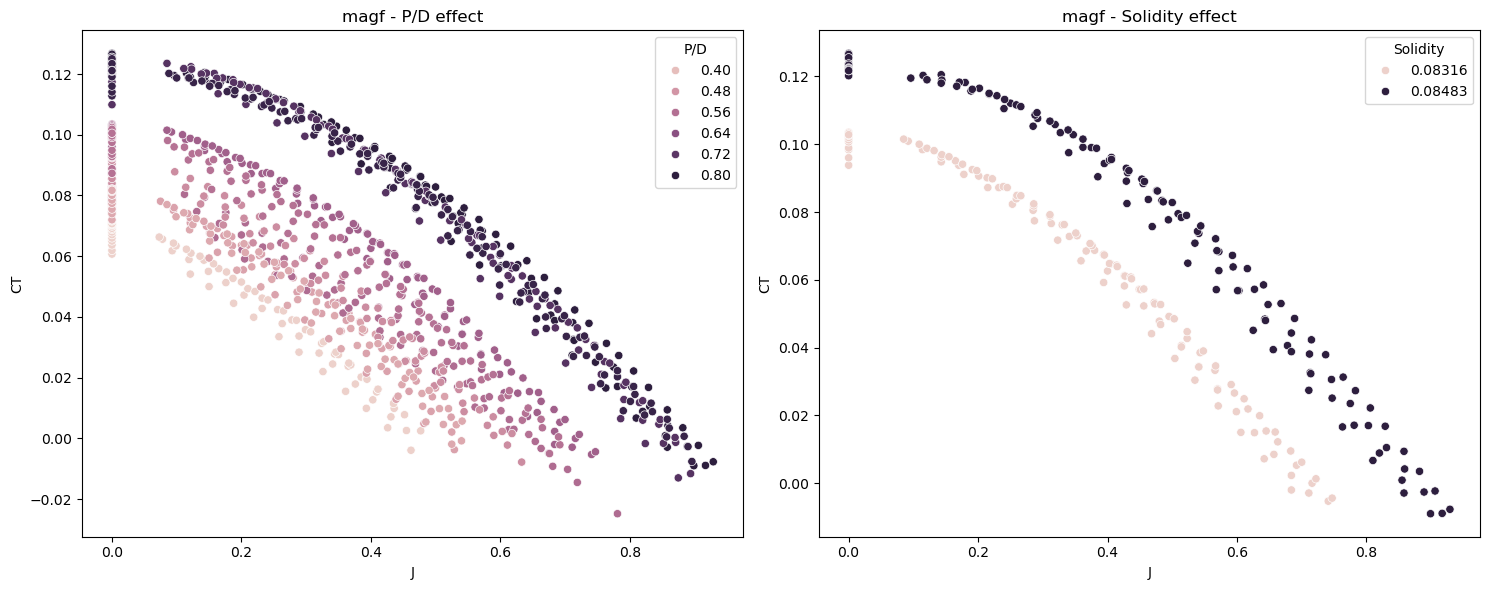

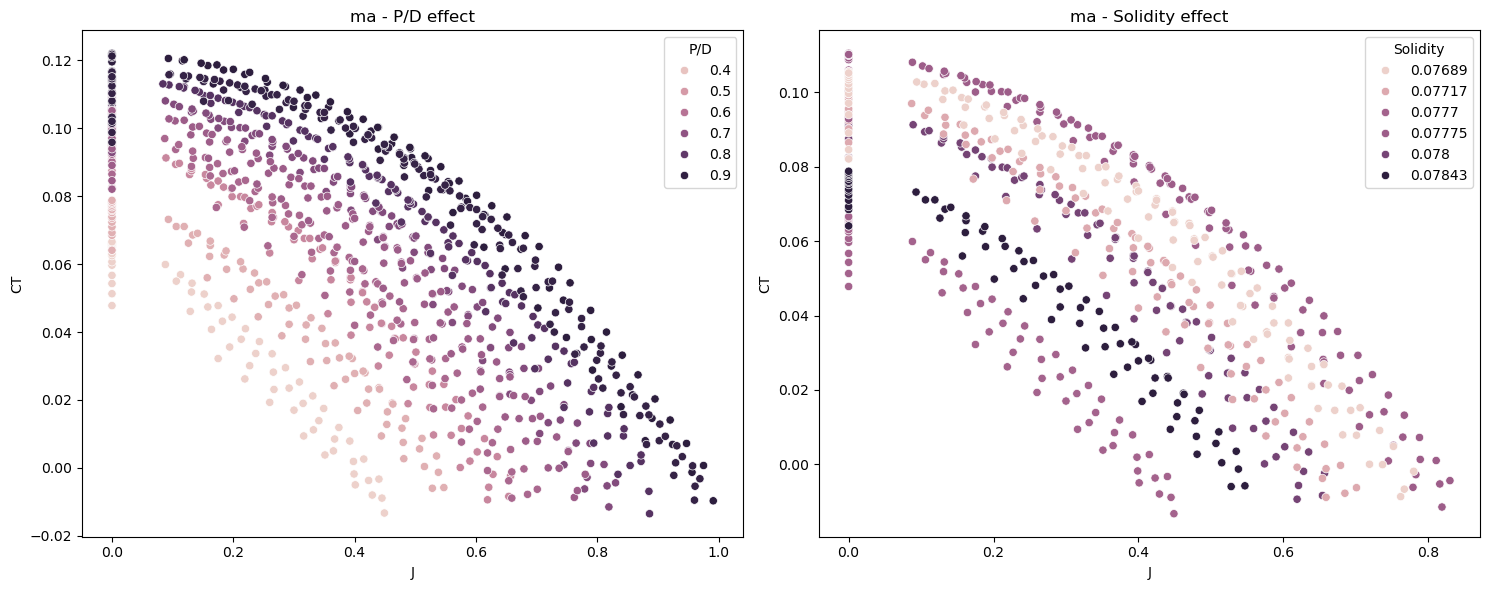

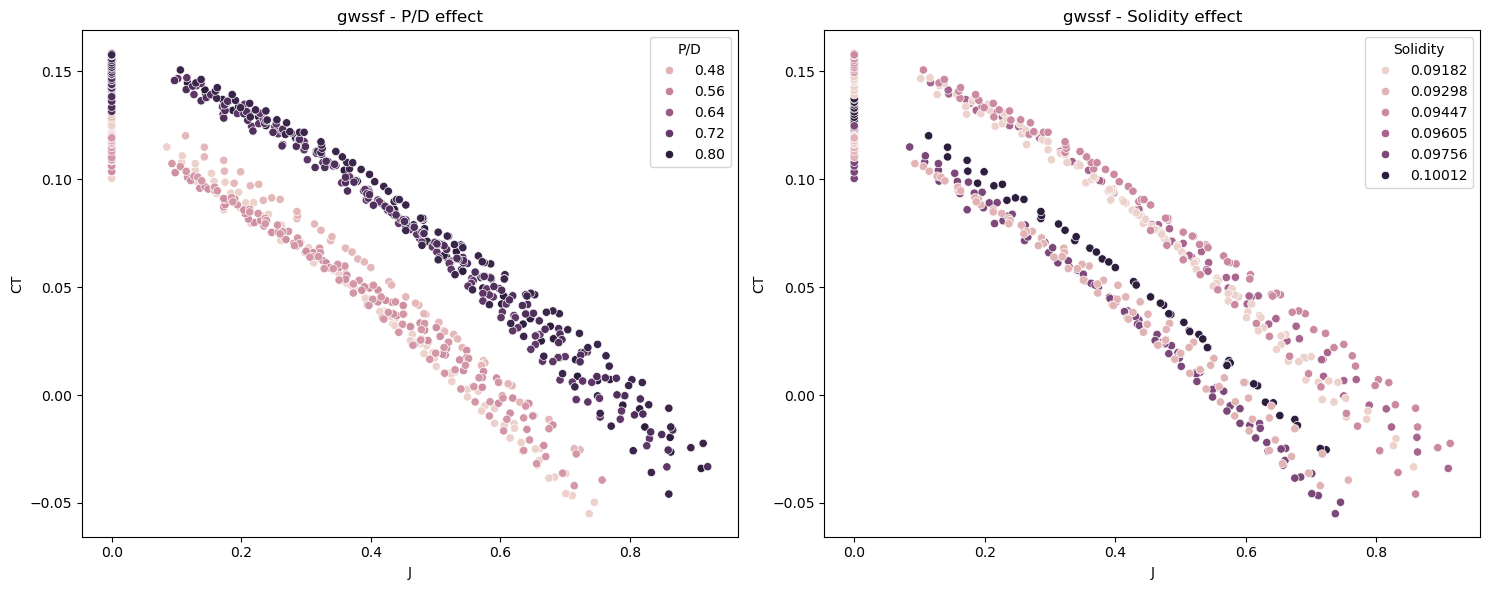

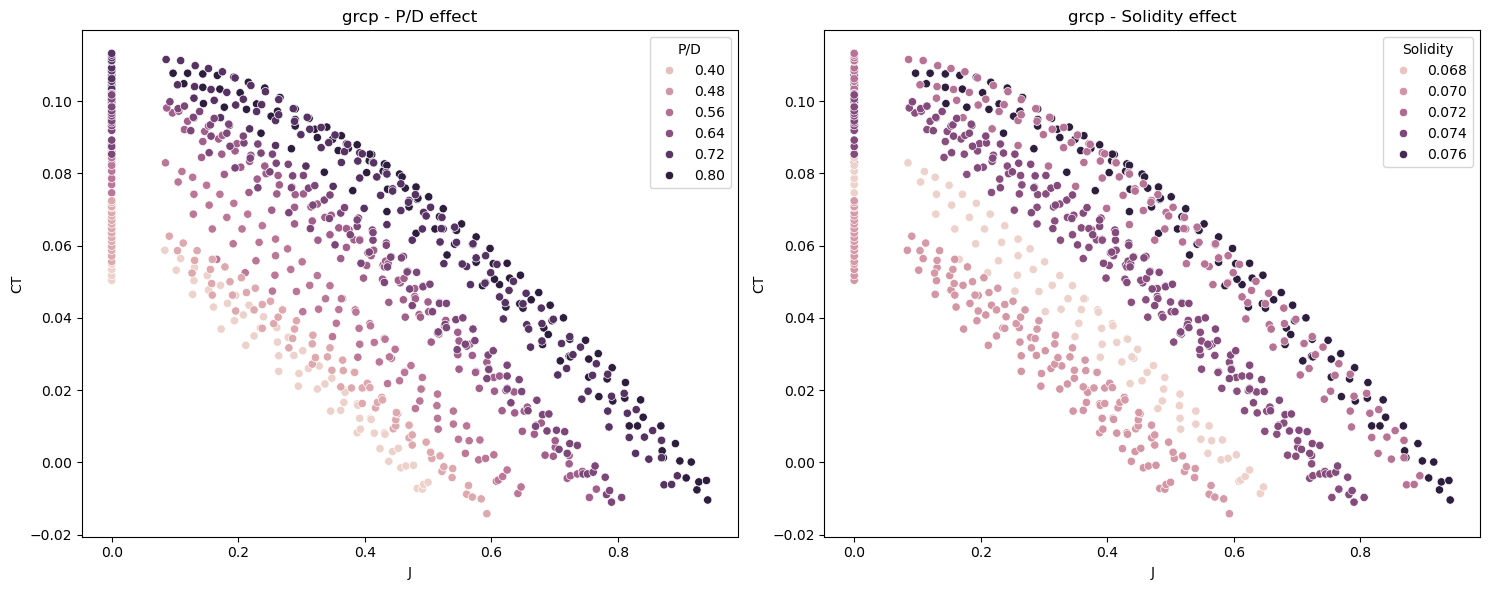

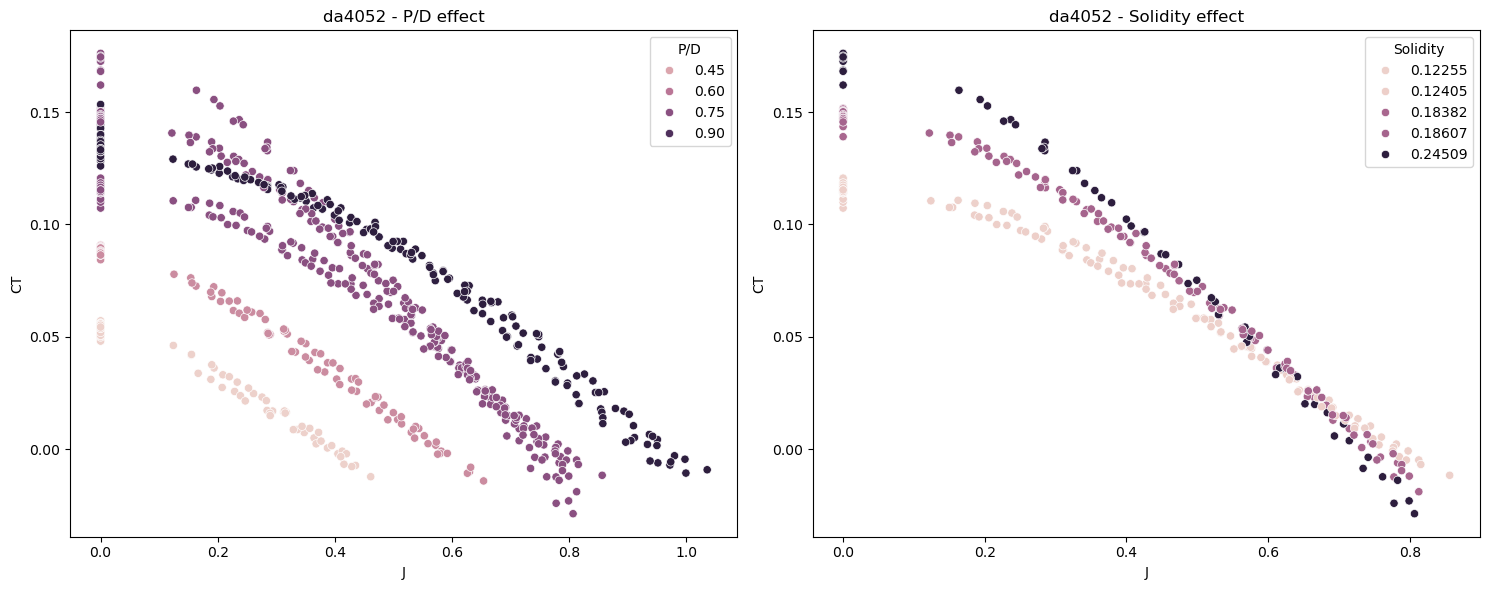

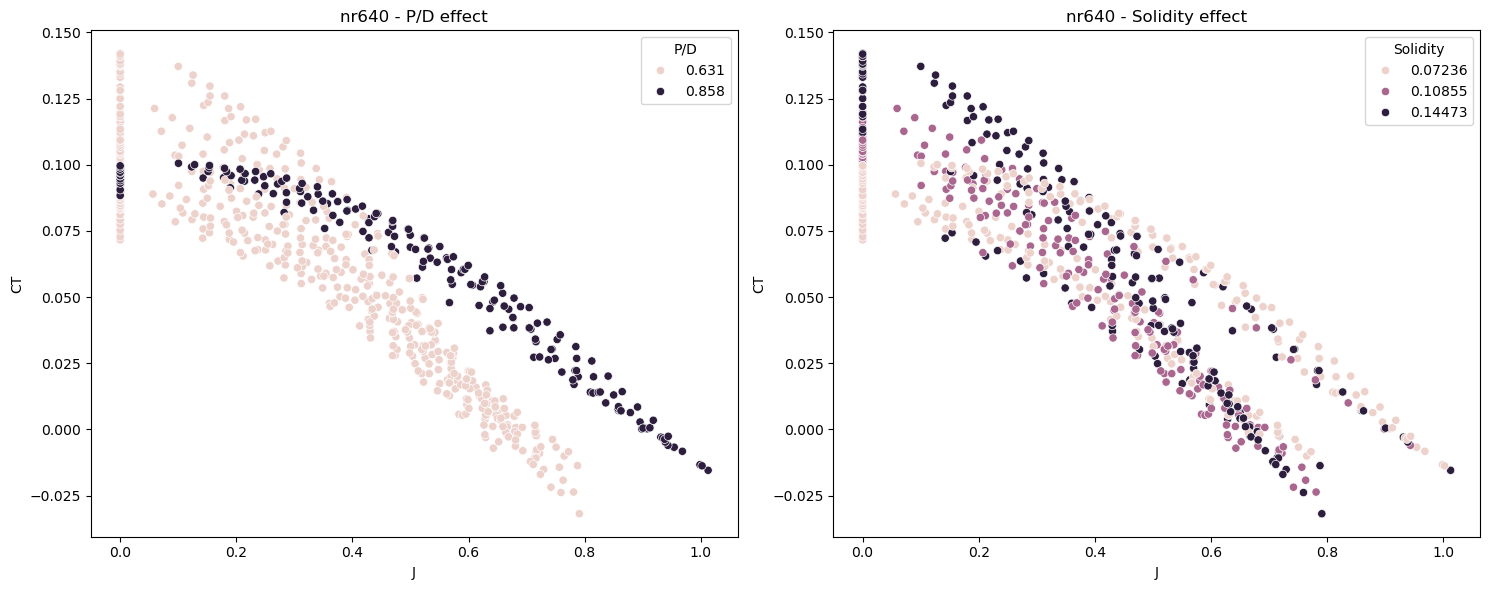

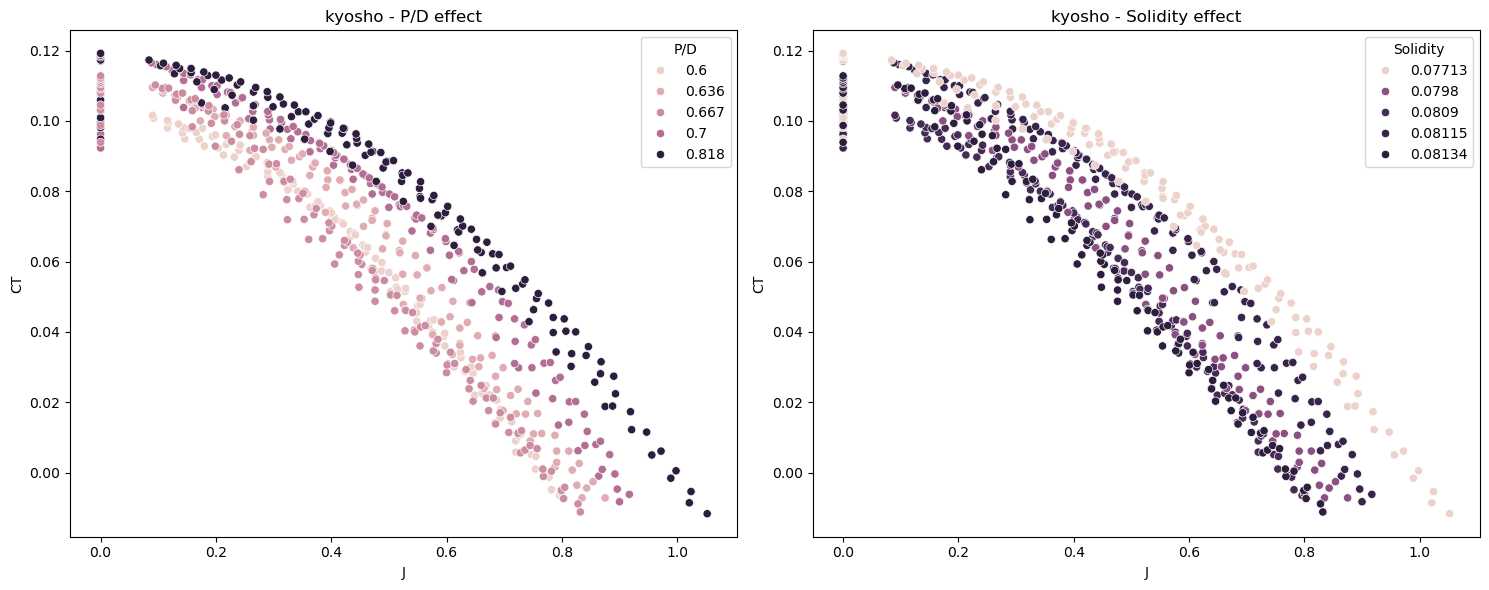

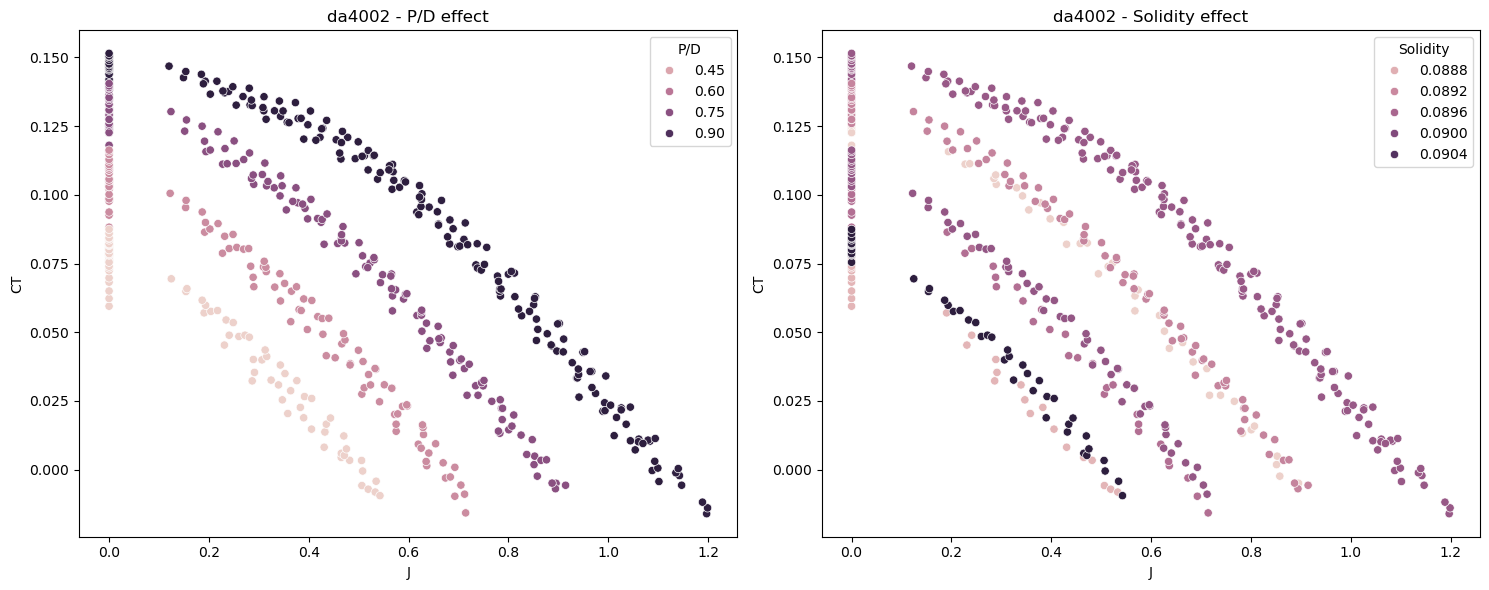

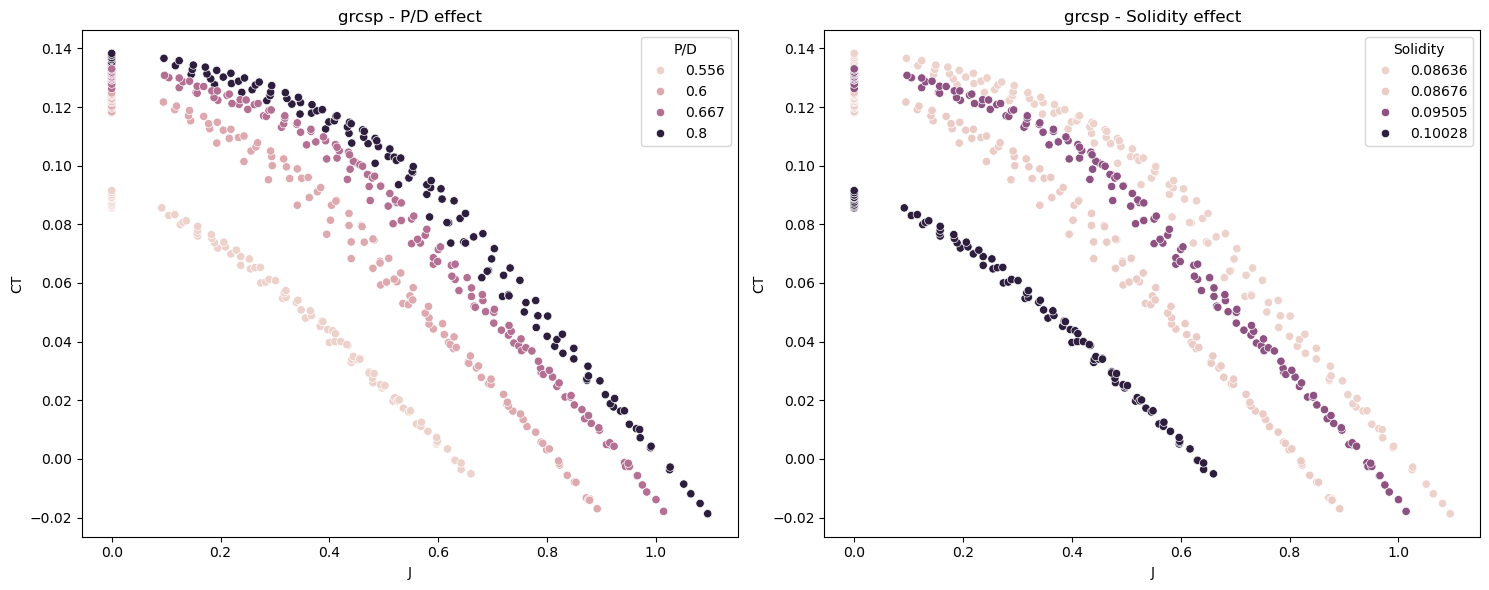

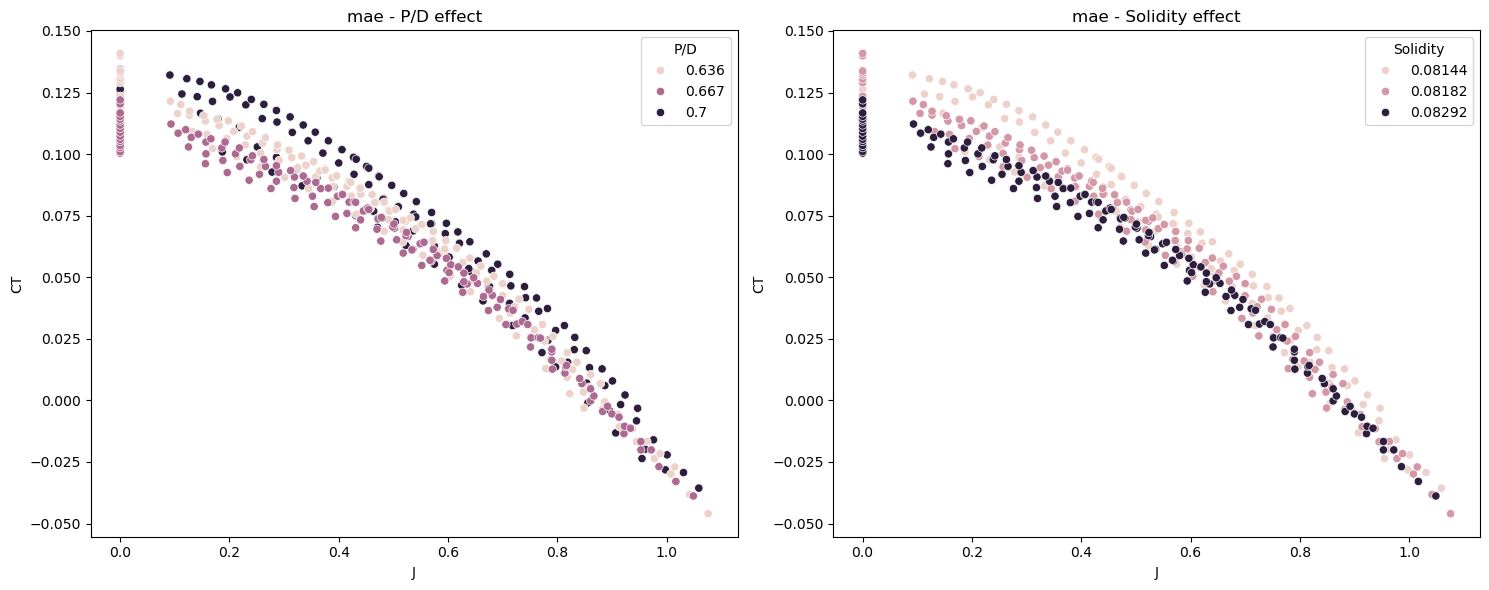

In [19]:
# 依據 P/D 和 Solidity 群組, 繪製 J vs. CT 散佈圖並理解資料特性.
for i, fam in enumerate(data['Family'].value_counts().index):
    
    # 先忽略 ancf 螺旋槳品牌
    if fam == 'ancf':
        continue
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].set_title(fam + ' - P/D effect')
    ax[1].set_title(fam + ' - Solidity effect')
    mask1 = data['Family'] == fam
    data_aux = data.loc[mask1, :]
    sns.scatterplot(data=data_aux, x='J', y='CT', hue = 'P/D', ax=ax[0])
    sns.scatterplot(data=data_aux, x='J', y='CT', hue = 'Solidity', ax=ax[1])
    ax[0].grid(False)
    ax[1].grid(False)
    fig.tight_layout()
    myfile = str(i) + '_' + fam + '_scatter.png'
    plt.savefig(myfile) # 輸出繪圖結果
    
    # i值大於15時,停止繪圖
    if i > 15:
        break

In [20]:
# 相關係數圖-所有變數
data_corr = data[['B', 'D', 'P', 'P/D', 'Solidity', 'J', 'N', 'CT', 'CP', 'eta']]
data_corr

B    D    P    P/D  Solidity      J         N        CT        CP  \
0      2  8.5  6.0  0.706       NaN  0.165  4000.000  0.099300  0.053900   
1      2  8.5  6.0  0.706       NaN  0.214  4000.000  0.094700  0.054300   
2      2  8.5  6.0  0.706       NaN  0.255  4000.000  0.091600  0.054800   
3      2  8.5  6.0  0.706       NaN  0.301  4000.000  0.084700  0.054000   
4      2  8.5  6.0  0.706       NaN  0.340  4000.000  0.079600  0.053000   
...   ..  ...  ...    ...       ...    ...       ...       ...       ...   
27490  2  9.0  7.0  0.778       NaN  0.000  5453.333  0.123695  0.063178   
27491  2  9.0  7.0  0.778       NaN  0.000  5960.000  0.123677  0.063333   
27492  2  9.0  7.0  0.778       NaN  0.000  6466.667  0.124291  0.063651   
27493  2  9.0  7.0  0.778       NaN  0.000  6960.000  0.125048  0.063481   
27494  2  9.0  7.0  0.778       NaN  0.000  7460.000  0.125666  0.063223   

         eta  
0      0.304  
1      0.374  
2      0.427  
3      0.473  
4      0.511  
...      ...  
27490  0.000  
27491  0.000  
27492  0.000  
27493  0.000  
27494  0.000  

[27495 rows x 10 columns]

<Axes: >

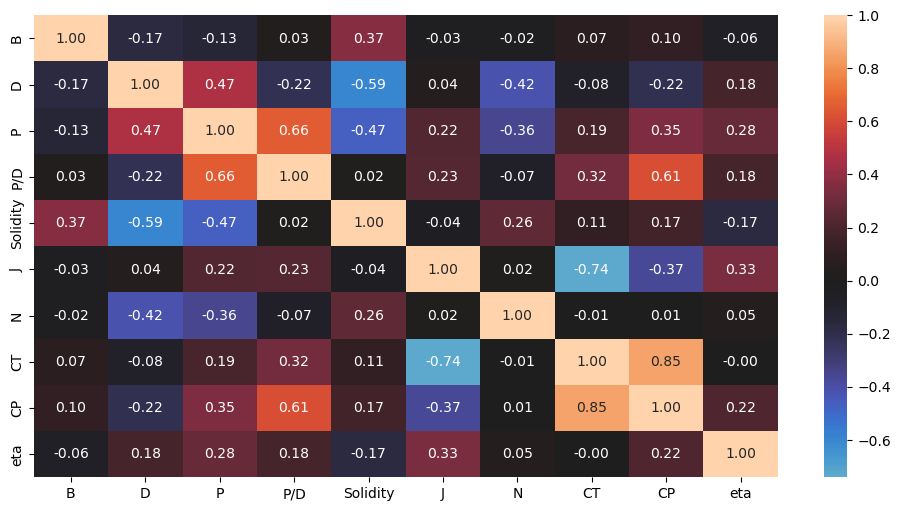

In [21]:
# 相關係數圖-所有變數-視覺化
# Solidity 與 D 和 P 具有高度負相關, 可以使用此關係建立插補遺漏值.
plt.figure(figsize=(12, 6))
sns.heatmap(data_corr.corr('spearman'), center=0, fmt='.2f', annot=True)

In [22]:
# 相關係數圖-篩選重要變數
props = data.drop(['PropName', 'BladeName', 'Family', 'J', 'N', 'CT', 'CP', 'eta'], axis=1).drop_duplicates().reset_index(drop=True)
props

B     D      P  Solidity    P/D
0    2   8.5   6.00       NaN  0.706
1    2   8.5   7.00       NaN  0.824
2    2   9.0   4.00       NaN  0.444
3    2   9.0   5.00   0.07286  0.556
4    2   7.4   8.25       NaN  1.115
..  ..   ...    ...       ...    ...
205  2  15.0  10.00       NaN  0.667
206  2  15.0   6.00       NaN  0.400
207  2  15.0   8.00       NaN  0.533
208  2  16.0   6.00       NaN  0.375
209  2  16.0   8.00       NaN  0.500

[210 rows x 5 columns]

<Axes: >

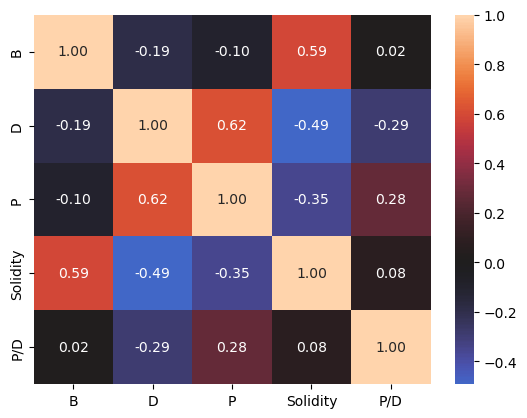

In [23]:
# 相關係數圖-篩選重要變數-視覺化
sns.heatmap(props.corr(), center=0, fmt='.2f', annot=True)

# 8. Solidity 遺漏值, 使用 KNN 填補法

In [24]:
# Solidity 變數有遺漏值, 其他變數沒有遺漏值.
data.isnull().sum(axis = 0)

PropName         0
BladeName        0
Family           0
B                0
D                0
P                0
J                0
N                0
CT               0
CP               0
eta              0
Solidity     13284
P/D              0
dtype: int64

In [25]:
# B 欄位(葉片數量)只有 3個值 [2,3,4] 差異較少, 因此填補 Solidity 欄位先考慮 'D', 'P' 二個變數
data['B'].unique()

array([2, 3, 4], dtype=int64)

In [26]:
# 先取出已知欄位: D, P, 與填補欄位 Solidity
X_imp = data.loc[:, ['D', 'P', 'Solidity']]
X_imp

D    P  Solidity
0      8.5  6.0       NaN
1      8.5  6.0       NaN
2      8.5  6.0       NaN
3      8.5  6.0       NaN
4      8.5  6.0       NaN
...    ...  ...       ...
27490  9.0  7.0       NaN
27491  9.0  7.0       NaN
27492  9.0  7.0       NaN
27493  9.0  7.0       NaN
27494  9.0  7.0       NaN

[27495 rows x 3 columns]

In [27]:
# 觀念說明: sklearn.impute.KNNImputer.fit vs. sklearn.impute.KNNImputer.fit_transform
# 將資料進行標準化, 使其轉換後之平均值為零且標準差為1, 計算式為 x′=(x−μ)/σ.
# 上述訓練集進行標準化後, 測試集亦須使用相同的μ與σ進行標準化.
# fit: 計算 μ, σ
# fit_transform: 先使用 fit 計算 μ, σ, 應用於 test dataset 時, 再使用 transform 進行資料轉換.

In [28]:
# 使用 KNNImputer 進行遺漏值填補法 (K近鄰法)
imp = KNNImputer(n_neighbors=5)

In [29]:
# 實際進行填補, 完成後將 array 轉換為 DataFrame, 須一些時間...
df = pd.DataFrame(imp.fit_transform(X_imp), columns = ['D', 'P', 'Solidity'])
df

D    P  Solidity
0      8.5  6.0   0.08292
1      8.5  6.0   0.08292
2      8.5  6.0   0.08292
3      8.5  6.0   0.08292
4      8.5  6.0   0.08292
...    ...  ...       ...
27490  9.0  7.0   0.09447
27491  9.0  7.0   0.09447
27492  9.0  7.0   0.09447
27493  9.0  7.0   0.09447
27494  9.0  7.0   0.09447

[27495 rows x 3 columns]

In [30]:
# Solidity 變數已經沒有遺漏值
df.isnull().sum(axis = 0)

D           0
P           0
Solidity    0
dtype: int64

In [31]:
# 將填補完成的 Solidity 值填入原 dat.
data.loc[:,'Solidity'] = df['Solidity']
data

PropName     BladeName Family  B    D    P      J         N  \
0      ance 8.5x6.0 - 2  ance 8.5x6.0   ance  2  8.5  6.0  0.165  4000.000   
1      ance 8.5x6.0 - 2  ance 8.5x6.0   ance  2  8.5  6.0  0.214  4000.000   
2      ance 8.5x6.0 - 2  ance 8.5x6.0   ance  2  8.5  6.0  0.255  4000.000   
3      ance 8.5x6.0 - 2  ance 8.5x6.0   ance  2  8.5  6.0  0.301  4000.000   
4      ance 8.5x6.0 - 2  ance 8.5x6.0   ance  2  8.5  6.0  0.340  4000.000   
...                 ...           ...    ... ..  ...  ...    ...       ...   
27490  ancf 9.0x7.0 - 2  ancf 9.0x7.0   ancf  2  9.0  7.0  0.000  5453.333   
27491  ancf 9.0x7.0 - 2  ancf 9.0x7.0   ancf  2  9.0  7.0  0.000  5960.000   
27492  ancf 9.0x7.0 - 2  ancf 9.0x7.0   ancf  2  9.0  7.0  0.000  6466.667   
27493  ancf 9.0x7.0 - 2  ancf 9.0x7.0   ancf  2  9.0  7.0  0.000  6960.000   
27494  ancf 9.0x7.0 - 2  ancf 9.0x7.0   ancf  2  9.0  7.0  0.000  7460.000   

             CT        CP    eta  Solidity    P/D  
0      0.099300  0.053900  0.304   0.08292  0.706  
1      0.094700  0.054300  0.374   0.08292  0.706  
2      0.091600  0.054800  0.427   0.08292  0.706  
3      0.084700  0.054000  0.473   0.08292  0.706  
4      0.079600  0.053000  0.511   0.08292  0.706  
...         ...       ...    ...       ...    ...  
27490  0.123695  0.063178  0.000   0.09447  0.778  
27491  0.123677  0.063333  0.000   0.09447  0.778  
27492  0.124291  0.063651  0.000   0.09447  0.778  
27493  0.125048  0.063481  0.000   0.09447  0.778  
27494  0.125666  0.063223  0.000   0.09447  0.778  

[27495 rows x 13 columns]

In [32]:
# 所有欄位皆無遺漏值
data.isnull().sum(axis = 0)

PropName     0
BladeName    0
Family       0
B            0
D            0
P            0
J            0
N            0
CT           0
CP           0
eta          0
Solidity     0
P/D          0
dtype: int64

In [33]:
# 資料型態
data.dtypes

PropName      object
BladeName     object
Family        object
B              int64
D            float64
P            float64
J            float64
N            float64
CT           float64
CP           float64
eta          float64
Solidity     float64
P/D          float64
dtype: object

In [34]:
# 資料摘要
data.describe(include='all')

PropName     BladeName Family             B             D  \
count               27495         27495  27495  27495.000000  27495.000000   
unique                240           226     32           NaN           NaN   
top     gwsdd 2.5x0.8 - 2  nr640 9x5.68   ancf           NaN           NaN   
freq                  243           276   5990           NaN           NaN   
mean                  NaN           NaN    NaN      2.045790      9.443751   
std                   NaN           NaN    NaN      0.266954      2.766641   
min                   NaN           NaN    NaN      2.000000      1.200000   
25%                   NaN           NaN    NaN      2.000000      9.000000   
50%                   NaN           NaN    NaN      2.000000     10.000000   
75%                   NaN           NaN    NaN      2.000000     11.000000   
max                   NaN           NaN    NaN      4.000000     19.000000   

                   P             J             N            CT            CP  \
count   27495.000000  27495.000000  27495.000000  27495.000000  27495.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        6.420748      0.423310   5470.285834      0.063996      0.046393   
std         2.411737      0.278554   2756.465916      0.044331      0.026629   
min         0.600000      0.000000    940.000000     -0.126140      0.002500   
25%         4.960000      0.208000   4012.000000      0.029395      0.026810   
50%         6.000000      0.429000   5018.000000      0.066372      0.043094   
75%         8.000000      0.622245   6021.000000      0.097700      0.060690   
max        13.000000      1.552000  27050.000000      0.253789      0.192791   

                 eta      Solidity           P/D  
count   27495.000000  27495.000000  27495.000000  
unique           NaN           NaN           NaN  
top              NaN           NaN           NaN  
freq             NaN           NaN           NaN  
mean        0.318133      0.090731      0.736685  
std         0.539775      0.031823      0.539980  
min       -22.698791      0.064620      0.048000  
25%         0.133000      0.076170      0.545000  
50%         0.456781      0.081150      0.667000  
75%         0.613000      0.094470      0.800000  
max         0.840262      0.300870      5.417000

In [35]:
# 計算 B 群組個數
data.groupby(['B'])['B'].count()
# B
# 2    26615
# 3      501
# 4      379

B
2    26615
3      501
4      379
Name: B, dtype: int64

In [36]:
# 計算 B 群組比例
data.groupby(['B'])['B'].count()/len(data.index)
# B
# 2    0.967994
# 3    0.018221
# 4    0.013784

B
2    0.967994
3    0.018221
4    0.013784
Name: B, dtype: float64

In [37]:
# end